# Reinforcement Learning - Practical Session 2


The goal of this practical session is to implement Value Iteration, Policy Iteration and Q-Learning for a GridWorld environment.

* Exercise 1: implement of the Bellman operator $T^*$ and verify its contraction property.
* Exercise 2: value iteration.
* Exercise 3: policy iteration.
* Exercise 4: Q-Learning.


## Review

A Markov Decision Process (MDP) is defined as tuple $(S, A, P, r, \gamma)$ where:
* $S$ is the state space
* $A$ is the action space 
* $P$ represents the transition probabilities, $P(s,a,s')$ is the probability of arriving at state $s'$ by taking action $a$ in state $s$
* $r$ is the reward function such that $r(s,a,s')$ is the reward obtained by taking action $a$ in state $s$ and arriving at $s'$
* $\gamma$ is the discount factor

A deterministic policy $\pi$ is a mapping from $S$ to $A$: $\pi(s)$ is the action to be taken at state $s$.

The goal of an agent is to find the policy $\pi$ that maximizes the expected sum of discounted rewards by following $\pi$. The value of $\pi$ is defined as

$$
V_\pi(s) = E\left[ \sum_{t=0}^\infty \gamma^t r(S_t, A_t, S_{t+1}) | S_0 = s \right]
$$

$V_\pi(s)$ and the optimal value function, defined as $V^*(s) = \max_\pi V_\pi(s)$, can be shown to satisfy the Bellman equations:

$$
V_\pi(s) = \sum_{s' \in S}  P(s,\pi(s),s')[r(s,\pi(s),s') + \gamma V_\pi(s')]
$$


$$
V^*(s) = \max_{a\in A} \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma V^*(s')]
$$

It is sometimes better to work with Q functions:

$$
Q_\pi(s, a) = \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma  Q_\pi(s', \pi(s')]
$$


$$
Q^*(s, a) = \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma \max_{a'} Q^*(s', a')]
$$

such that $V_\pi(s) = Q_\pi(s, \pi(s))$ and $V^*(s) = \max_a Q^*(s, a)$.


### Using value iteration to compute an optimal policy
If the reward function and the transition probabilities are known (and the state and action spaces are not very large), we can use dynamic programming methods to compute $V^*(s)$. Value iteration is one way to do that.


#####  Value iteration to compute $V^*(s)$
$$
T^* Q(s,a) = \sum_{s'}P(s'|s,a)[ r(s, a, s') + \gamma \max_{a'} Q(s', a')]   \\
$$


* For any $Q_0$, let $Q_n = T^* Q_{n-1}$. 
* We have $\lim_{n\to\infty}Q_n = Q^*$ and $Q^* = T^* Q^*$


##### Finding the optimal policy from $V^\pi(s)$

The optimal policy $\pi^*$ can be computed as

$$
\pi^*(s) \in \arg\max_{a\in A} Q^*(s, a) =  \arg\max_{a\in A} \sum_{s' \in S}  P(s,a,s')[r(s,a,s') + \gamma V^*(s')]
$$

In [1]:
import sys
sys.path.append('utils')
import numpy as np
import matplotlib.pyplot as plt
from utils.envs import ToyEnv1, SimpleGridWorld

# GridWorld environment

(You can use a simpler environment, __ToyEnv1__ to debug your algorithms)

In [2]:
# Small environment for debugging
env = SimpleGridWorld(gamma=0.95, success_probability=1.0)
# env = ToyEnv1(gamma=0.95)

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_fn(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

# Visualizing the environment
try:
    print("Visualization:")
    env.render()
except:
    pass # render not available

print(env.step(1))
env.render()

Set of states: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Set of actions: [0, 1, 2, 3]
Number of states:  18
Number of actions:  4
P has shape:  (18, 4, 18)
discount factor:  0.95

initial state:  0
reward at (s=1, a=3,s'=2):  -1

random policy =  [0 1 2 0 3 0 2 0 2 3 3 3 2 1 0 3 3 3]
(s, a, s', r):
0 0 0 0.0
0 0 0 0.0
0 0 0 0.0
0 0 0 0.0

Visualization:
A  -  -  -  -  + 
o  o  o  o  o  o 
o  o  o  o  o  o 

(1, -1, False, {})
o  A  -  -  -  + 
o  o  o  o  o  o 
o  o  o  o  o  o 



# Exercise 1: Bellman operator

1. Write a function that takes an environment and a state-action value function $Q$ as input and returns the Bellman optimality operator applied to $Q$, $T^* Q$ and the greedy policy with respect to $Q$.
3. Let $Q_1$ and $Q_2$ be state-action value functions. Verify the contraction property:  $\Vert T^* Q_1 - T^* Q_2\Vert \leq \gamma ||Q_1 - Q_2||$, where $||Q|| = \max_{s,a} |Q(s,a)|$.

In [3]:
# --------------
# Your answer to 1.
# --------------
def bellman_operator(Q, env):
    TQ = np.zeros((env.Ns, env.Na))
    greedy_policy = np.zeros(env.Ns)
    for s in env.states:
        for a in env.actions:
            prob = env.P[s, a, :]
            rewards = np.array([float(env.reward_fn(s,a, s_)) for s_ in env.states])
            TQ[s,a] = np.sum( prob*(rewards + env.gamma*Q.max(axis=1))  )

    argmax = np.argmax(TQ, axis = 1)
    greedy_policy = argmax
    
    return TQ, greedy_policy

In [4]:
# --------------
# Your answer to 2.
# --------------
n_simulations = 15

print("Contraction of Bellman operator: ")
for ii in range(n_simulations):
    Q1 = np.random.randn(env.Ns, env.Na)
    Q2 = np.random.randn(env.Ns, env.Na)

    # Contraction of Bellman operator
    contraction = np.abs(bellman_operator(Q1, env)[0] - bellman_operator(Q2, env)[0]).max() / np.abs(Q1-Q2).max()
    print(contraction)
    assert contraction <= env.gamma + 1e-12

Contraction of Bellman operator: 
0.5916455856246124
0.6736793086199777
0.39967742490511116
0.8943852829872322
0.5185774272425614
0.32226252068392547
0.4547993934537228
0.45923138496643207
0.5611003368343374
0.6660178931065607
0.5612756281494009
0.48910149422224564
0.7497863508561882
0.5848743464003708
0.41802366372129474


# Exercise 2: Value iteration (VI)

1. (Optimal Value function) Write a function that takes as input an initial state-action value function `Q0` and an environment `env` and returns a vector `Q` such that $||T^* Q -  Q ||_\infty \leq \varepsilon $ and the greedy policy with respect to $Q$.
2. Test the convergence of the function you implemented.

In [5]:
# --------------
# Your answer to 1.
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    """
    Finding the optimal value function. To be done!
    """
    it = 1
    Q = Q0
    while True:
        TQ, greedy_policy = bellman_operator(Q, env)

        err = np.abs(TQ-Q).max() 
        if err < epsilon:
            return TQ, greedy_policy

        Q = TQ
        it += 1

In [6]:
# --------------
# Your answer to 2.
# --------------
epsilon = 1e-6
Q0 = np.zeros((env.Ns, env.Na))

Q, greedy_policy = value_iteration(Q0, env, epsilon)
err = np.abs(Q - bellman_operator(Q, env)[0]).max()
print("norm of T(Q) - Q = ", err)
assert err <= epsilon
print(greedy_policy)

# simulate optimal policy for some steps
state = env.reset()
env.render()
for t in range(7):
    action = greedy_policy[state]
    next_state, reward, done, info = env.step(action)
    env.render()
    state = next_state



norm of T(Q) - Q =  9.185378004872291e-07
[3 3 3 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2]
A  -  -  -  -  + 
o  o  o  o  o  o 
o  o  o  o  o  o 

o  -  -  -  -  + 
A  o  o  o  o  o 
o  o  o  o  o  o 

o  -  -  -  -  + 
o  A  o  o  o  o 
o  o  o  o  o  o 

o  -  -  -  -  + 
o  o  A  o  o  o 
o  o  o  o  o  o 

o  -  -  -  -  + 
o  o  o  A  o  o 
o  o  o  o  o  o 

o  -  -  -  -  + 
o  o  o  o  A  o 
o  o  o  o  o  o 

o  -  -  -  -  + 
o  o  o  o  o  A 
o  o  o  o  o  o 

o  -  -  -  -  A 
o  o  o  o  o  o 
o  o  o  o  o  o 



# Exercise 3: Policy iteration (PI)

Policy iteration is another algorithm to find an optimal policy when the MDP is known:

$$
\pi_{n} \gets \mathrm{greedy}(V_{\pi_{n-1}}) \\
V_{\pi_n} \gets \mbox{policy-evaluation}(\pi_n)
$$
For any arbitrary $\pi_0$, $\pi_n$ converges to $\pi^*$.

Implement policy iteration and compare it to value iteration.


### Exact policy evaluation

Each iteration of PI requires a policy evaluation. This step can be done with value iteration, but the value of a policy can also be computed exactly by solving a linear system: $(I - \gamma P_\pi) V^\pi = r_\pi $ where $P_\pi$ is the transition kernel (matrix) induced by $\pi$: $P_\pi(s, s') = P(S_{t+1}=s' | S_t = s, A_t = \pi(s)) $ and $r_\pi(s') = \sum_{s} r(s,\pi(s),s') P(S_{t+1}=s' | S_t = s, A_t = \pi(s)) $ is the average reward obtained in state $s'$ by following the policy $\pi$.  

In [20]:
def exact_policy_eval(pi, env):
    # Compute the transition matrix P_pi and reward vector r_pi
    P_pi = np.zeros((env.Ns, env.Ns))
    r_pi = np.zeros(env.Ns)
    
    for s in env.states:
        for s_ in env.states:
            a = pi[s]
            P_pi[s, s_] += env.P[s,a,s_]
            r_pi[s] += env.reward_fn(s,a,s_)*env.P[s,a,s_]

    A = np.eye(env.Ns) - env.gamma*P_pi
    b = r_pi

    # Solve linear system
    V = np.linalg.solve(A, b)
    
    return V

In [37]:
def policy_iteration(pi0, env):
    it = 1
    policy = pi0
    while True:
        # Policy evaluation
        V = exact_policy_eval(policy, env)

        # Policy improvement
        Q = np.zeros((env.Ns, env.Na))
        for s in env.states:
            for a in env.actions:
                prob = env.P[s, a, :]
                rewards = np.array([float(env.reward_fn(s,a, s_)) for s_ in env.states])
                Q[s,a] = np.sum( prob*(rewards + env.gamma*V)  )
        greedy_policy = Q.argmax(axis=1)
        
        if np.array_equal(policy, greedy_policy):
            print("(policy iteration) number of iterations = ", it)
            return greedy_policy

        policy = greedy_policy
        it += 1

In [25]:
Q0 = np.zeros((env.Ns, env.Na))
pi0 = np.random.randint(env.Na, size = (env.Ns,))

_, greedy_policy = value_iteration(Q0, env)
pi = policy_iteration(pi0, env)

print(pi)  # policu returned by policy iteration
print(greedy_policy) # greedy policy obtained with value iteration

number of iterations =  6
[3 3 3 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2]
[3 3 3 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2]


# Exercise 4: Q-Learning


###  Q-Learning 

When the reward function and the transition probabilities are *unknown*, we cannot use dynamic programming to find the optimal value function. Q-Learning is a stochastic approximation algorithm that allows us to estimate the value function by using only samples from the environment.

Q-learning with $\varepsilon$-greedy exploration does the following update at time $t$:

1. In state $s_t$, take action $a_t$  such that $a_t$ is random with probability $\varepsilon$ and $a_t \in \arg\max_a \hat{Q}_t(s_t,a) $ with probability $1-\varepsilon$;
2. Observe $s_{t+1}$ and reward $r_t$;
3. Compute $\delta_t = r_t + \gamma \max_a \hat{Q}_t(s_{t+1}, a) - \hat{Q}_t(s_t, a_t)$;
4. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}  $



#####  Q-learning

The Q-Learning algorithm allows us to estimate the optimal Q function using only trajectories from the MDP obtained by following some exploration policy. 

Q-learning with $\varepsilon$-greedy exploration does the following update at time $t$:

1. In state $s_t$, take action $a_t$  such that $a_t$ is random with probability $\varepsilon$ and $a_t \in \arg\max_a \hat{Q}_t(s_t,a) $ with probability $1-\varepsilon$ (**act function**);
2. Observe $s_{t+1}$ and reward $r_t$ (**step in the environment**);
3. Compute $\delta_t = r_t + \gamma \max_a \hat{Q}_t(s_{t+1}, a) - \hat{Q}_t(s_t, a_t)$ (**to be done in .update()**) ;
4. Update $\hat{Q}_{t+1}(s, a) = \hat{Q}_t(s, a) + \alpha_t(s,a)\delta_t\mathbb{1}\{s=s_t, a=a_t\}$ (**in update() too**)


Implement Q-learning and test its convergence.

In [35]:
#-------------------------------
# Q-Learning implementation
# ------------------------------

class QLearning:
    """
    Implements Q-learning algorithm with epsilon-greedy exploration
    """
    def __init__(self, env, gamma, learning_rate=None, min_learning_rate=0.0, epsilon=1.0, epsilon_decay=0.995,
                 epsilon_min=0.01, rmax=1.0, seed=42):
        self.env = env
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_learning_rate = min_learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.Q = np.ones((env.Ns, env.Na))*rmax/(1.0-gamma)
        self.Nsa = np.zeros((env.Ns, env.Na))
        self.state = env.reset()
        self.RS = np.random.RandomState(seed)

    def get_delta(self, r, x, a, y):
        """
        :param r: reward
        :param x: current state
        :param a: current action
        :param y: next state
        :return:
        """
        max_q_y_a = self.Q[y, self.env.available_actions()].max()
        q_x_a = self.Q[x, a]

        return r + self.gamma*max_q_y_a - q_x_a

    def get_learning_rate(self, s, a):
        if self.learning_rate is None:
            return max(1.0/max(1.0, self.Nsa[s, a])**0.8, self.min_learning_rate)
        else:
            return max(self.learning_rate, self.min_learning_rate)
    
    def act(self, state, greedy=False): # You don't have to use this template for your algorithm, those are just hints
        """
        Takes a state as input and outputs an action (acting greedily or not with respect to the q function)
        """
        if self.RS.uniform(0, 1) < self.epsilon:
            # explore
            return np.random.choice(self.env.available_actions())
        else:
            # exploit
            state = self.env.state
            actions = self.env.available_actions()
            temp = np.max(self.Q[state, actions])
            a = np.abs(self.Q[state, :]-temp).argmin()
            return a
    
    def step(self):
        """
        Takes (s, a, s', r) as input and update the Q function
        """
        # Current state
        x = self.env.state

        # Choose action
        a = self.act(x)

        # Learning rate
        alpha = self.get_learning_rate(x, a)

        # Take step
        observation, reward, done, info = self.env.step(a)
        y = observation
        r = reward
        delta = self.get_delta(r, x, a, y)

        # Update
        self.Q[x, a] = self.Q[x, a] + alpha*delta

        self.Nsa[x, a] += 1
        self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

        if done:
            self.env.reset()

(policy iteration) number of iterations =  9
optimal value function: [14.70183781 15.47561875 16.290125   18.         20.         20.
 15.47561875 16.290125   17.1475     18.05       19.         20.
 14.70183781 15.47561875 16.290125   17.1475     18.05       19.        ]
q learning estimate:  [14.70314975 15.81032404 16.48738376 18.         20.         20.
 15.47588145 16.29016822 17.14750501 18.05000029 19.         20.
 15.8156555  16.06615545 16.53638802 17.22709206 18.05601478 19.        ]


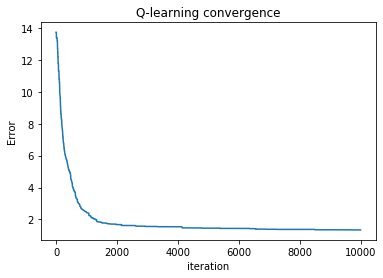

In [42]:
# ---------------------------
# Convergence of Q-Learning
# ---------------------------

# Number of Q learning iterations
n_steps = int(1e4)  

# Policy iteration and evaluation (to get exact optimal V)
pi0 = np.zeros(env.Ns, dtype=np.int32)  # initial policy
pi_opt = policy_iteration(pi0, env)
v_opt = exact_policy_eval(pi_opt, env)

# Create qlearning object
qlearning = QLearning(env, gamma=env.gamma, learning_rate=None)

# Run Q Learning
tt = 0
v_list = np.zeros((n_steps, env.Ns))
while tt < n_steps:
    qlearning.step()
    # Estimate V*
    v_star_est = qlearning.Q.max(axis=1)
    v_list[tt, :] = v_star_est
    tt +=1

# Compute greedy policy
greedy_policy = np.argmax(qlearning.Q, axis=1)

# Plot
diff = v_list - v_opt
norm_diff = np.linalg.norm(diff, axis=1)
plt.plot(norm_diff)
plt.xlabel('iteration')
plt.ylabel('Error')
plt.title("Q-learning convergence")

print("optimal value function:", v_opt)
print("q learning estimate: ", v_list[-1, :])